In [20]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow_addons.optimizers import AdamW, Yogi  # You need TensorFlow Addons for AdamW and Yogi
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

In [6]:
class DataPreprocessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None
        self.X_train = None
        self.X_test = None
        self.X_val = None
        self.y_train = None
        self.y_test = None
        self.y_val = None
        # self.Xc = None
        # self.yc = None
    def load_data(self):
        self.data = pd.read_csv(self.file_path)
        # self.Xc = self.data.iloc[:, 1:]
        # self.yc = self.data.iloc[:, 0:1]
    def remove_nan(self):
        self.data = self.data.fillna(0)
        
    def one_hot_encode(self, columns):
        self.data = pd.get_dummies(self.data, columns=columns)

    def normalize(self, features):
        for feature in features:
            self.data[feature] = self.data[feature] / (800 if feature == 'gre' else 4)

    def shuffle_data(self):
        self.data = self.data.sample(frac=1).reset_index(drop=True)

    def preprocess(self):
        self.load_data()
        self.remove_nan()
        self.one_hot_encode(['rank'])
        self.normalize(['gre', 'gpa'])
        self.shuffle_data()

        X = self.data.iloc[:, 1:].values.astype('float32')
        y = keras.utils.to_categorical(self.data["admit"], 2)
        Xc = self.data.iloc[:, 1:]
        yc = self.yc = self.data.iloc[:, 0:1]
        # Split the data into train, test, and validation sets
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
        X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

        self.X_train = X_train
        self.X_test = X_test
        self.X_val = X_val
        self.y_train = y_train
        self.y_test = y_test
        self.y_val = y_val

        # return X_train, X_test, X_val, y_train, y_test, y_val, Xc, yc
        return X_train, X_test, X_val, y_train, y_test, y_val


In [123]:
class NeuralNetworkModel:
    def __init__(self):
        self.model = None

    def build_ann(self, input_shape, optimizer='adam'):
        self.model = Sequential()
        self.model.add(Dense(16, activation='relu', input_shape=(input_shape,)))
        # self.model.add(Dropout(0.2))
        self.model.add(Dense(8, activation='relu'))
        # self.model.add(Dropout(0.1))
        self.model.add(Dense(2, activation='sigmoid'))
        self.model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
        return self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

    def evaluate(self, X_test, y_test):
        y_pred_prob = self.model.predict(X_test)
        y_pred = np.round(y_pred_prob).astype(int).flatten()
        if isinstance(y_test, pd.Series):
           y_test = y_test.values
        y_true = y_test.flatten()
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        return accuracy, precision, recall, f1

In [124]:
# Example usage:
data_preprocessor = DataPreprocessor(file_path='student_data.csv')
# X_train, X_test, X_val, y_train, y_test, y_val, Xc , yc = data_preprocessor.preprocess()
X_train, X_test, X_val, y_train, y_test, y_val = data_preprocessor.preprocess()


In [125]:
# data = pd.read_csv('student_data.csv')
# data.head(5)

In [126]:
# # Define reduction percentages
# reduction_percentage = 0.7

# # Reduce the size of the datasets
# X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=reduction_percentage, random_state=42)
# X_val, _, y_val, _ = train_test_split(X_val, y_val, test_size=reduction_percentage, random_state=42)
# X_test, _, y_test, _ = train_test_split(X_test, y_test, test_size=reduction_percentage, random_state=42)

In [127]:
X_train.shape , X_val.shape, X_test.shape, y_train.shape

((320, 7), (40, 7), (40, 7), (320, 2))

In [128]:
# List of optimizers to test for NN
optimizers = {
    'SGD': SGD(),
    'SGD_momentum': SGD(momentum=0.9),
    'Nesterov': SGD(momentum=0.9, nesterov=True),
    'RMSprop': tf.keras.optimizers.RMSprop(),
    'Adagrad': tf.keras.optimizers.Adagrad(),
    'Adadelta': tf.keras.optimizers.Adadelta(),
    'Adam': Adam(),
    'AMSGrad': Adam(amsgrad=True),
    'AdamW': AdamW(weight_decay=1e-4),
    'Yogi': Yogi(),
    'Nadam': tf.keras.optimizers.Nadam(),
    'Adamax': tf.keras.optimizers.Adamax()
}

results = {}

# neural_network_model = NeuralNetworkModel()

for name, optimizer in optimizers.items():
    print(f"Training model with {name} optimizer...")
    neural_network_model = NeuralNetworkModel()
    neural_network_model.build_ann(X_train.shape[1], optimizer=optimizer)
    start_time = time.time()
    history = neural_network_model.train(X_train, y_train, X_val, y_val, epochs=50, batch_size=32)
    end_time = time.time()
    test_accuracy, precision, recall, f1 = neural_network_model.evaluate(X_test, y_test)
    training_time = end_time - start_time
    convergence_speed = len(history.history['loss'])
    results[name] = {
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'convergence_speed': convergence_speed,
        'training_time': training_time,
        'history': history
    }

Training model with SGD optimizer...
Epoch 1/50
10/10 [==============================] - 1s 26ms/step - loss: 0.6671 - accuracy: 0.6562 - val_loss: 0.6473 - val_accuracy: 0.7250 - lr: 0.0100
Epoch 2/50
10/10 [==============================] - 0s 13ms/step - loss: 0.6650 - accuracy: 0.6562 - val_loss: 0.6443 - val_accuracy: 0.7250 - lr: 0.0100
Epoch 3/50
10/10 [==============================] - 0s 13ms/step - loss: 0.6630 - accuracy: 0.6562 - val_loss: 0.6415 - val_accuracy: 0.7250 - lr: 0.0100
Epoch 4/50
10/10 [==============================] - 0s 12ms/step - loss: 0.6611 - accuracy: 0.6594 - val_loss: 0.6389 - val_accuracy: 0.7250 - lr: 0.0100
Epoch 5/50
10/10 [==============================] - 0s 11ms/step - loss: 0.6592 - accuracy: 0.6594 - val_loss: 0.6364 - val_accuracy: 0.7250 - lr: 0.0100
Epoch 6/50
10/10 [==============================] - 0s 11ms/step - loss: 0.6575 - accuracy: 0.6594 - val_loss: 0.6341 - val_accuracy: 0.7250 - lr: 0.0100
Epoch 7/50
10/10 [=====================

In [129]:
# Print results
print("\nResults:")
for name, result in results.items():
    print(f"{name}: Test Accuracy - {result['test_accuracy']:.4f}, "
          f"Precision - {result['precision']:.4f}, "
          f"Recall - {result['recall']:.4f}, "
          f"F1-score - {result['f1_score']:.4f}, "
          f"Convergence Speed - {result['convergence_speed']} epochs, "
          f"Training Time - {result['training_time']:.2f} seconds")


Results:
SGD: Test Accuracy - 0.8500, Precision - 0.8500, Recall - 0.8500, F1-score - 0.8500, Convergence Speed - 50 epochs, Training Time - 6.39 seconds
SGD_momentum: Test Accuracy - 0.8500, Precision - 0.8500, Recall - 0.8500, F1-score - 0.8500, Convergence Speed - 32 epochs, Training Time - 4.18 seconds
Nesterov: Test Accuracy - 0.8500, Precision - 0.8500, Recall - 0.8500, F1-score - 0.8500, Convergence Speed - 16 epochs, Training Time - 2.40 seconds
RMSprop: Test Accuracy - 0.8250, Precision - 0.8325, Recall - 0.8250, F1-score - 0.8240, Convergence Speed - 48 epochs, Training Time - 7.24 seconds
Adagrad: Test Accuracy - 0.5375, Precision - 0.5791, Recall - 0.5375, F1-score - 0.4675, Convergence Speed - 50 epochs, Training Time - 6.39 seconds
Adadelta: Test Accuracy - 0.2125, Precision - 0.2079, Recall - 0.2125, F1-score - 0.2094, Convergence Speed - 50 epochs, Training Time - 7.05 seconds
Adam: Test Accuracy - 0.8500, Precision - 0.8500, Recall - 0.8500, F1-score - 0.8500, Converg

In [130]:
# Data extraction for the summary
data_info = {
    'Data Name': ["Student Admission"] * len(optimizers),
    'Data Size': [X_train.shape[0]] * len(optimizers),
    'Number of Features': [X_train.shape[1]] * len(optimizers),
    'Target Feature Type': [y_train.dtype] * len(optimizers),
    'Neural Network Architecture': ["FNN"] * len(optimizers),
    'Optimization Method': list(optimizers.keys())
}

# Extract results for each optimization method
results_info = {
    'Optimization Method': [],
    'Test Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-score': [],
    'Convergence Speed': [],
    'Training Time': [],
    'Training Loss': [],
    'Validation Loss': []
}

# Add the evaluation results for each optimizer
for optimizer, result in results.items():
    results_info['Optimization Method'].append(optimizer)
    results_info['Test Accuracy'].append(result['test_accuracy'])
    results_info['Precision'].append(result['precision'])
    results_info['Recall'].append(result['recall'])
    results_info['F1-score'].append(result['f1_score'])
    results_info['Convergence Speed'].append(result['convergence_speed'])
    results_info['Training Time'].append(result['training_time'])
    results_info['Training Loss'].append(result['history'].history['loss'][0])
    results_info['Validation Loss'].append(result['history'].history['val_loss'][0])

# Create DataFrames and merge them for final results
data_df = pd.DataFrame(data_info)
results_df = pd.DataFrame(results_info)
final_df = pd.merge(data_df, results_df, on='Optimization Method')

# Show the final merged data
final_df.head(12)

,Data Name,Data Size,Number of Features,Target Feature Type,Neural Network Architecture,Optimization Method,Test Accuracy,Precision,Recall,F1-score,Convergence Speed,Training Time,Training Loss,Validation Loss
0,Student Admission,320,7,float32,FNN,SGD,0.8500,0.850000,0.8500,0.850000,50,6.386514,0.667109,0.647267
1,Student Admission,320,7,float32,FNN,SGD_momentum,0.8500,0.850000,0.8500,0.850000,32,4.183138,0.705278,0.689193
2,Student Admission,320,7,float32,FNN,Nesterov,0.8500,0.850000,0.8500,0.850000,16,2.397395,0.674329,0.657500
3,Student Admission,320,7,float32,FNN,RMSprop,0.8250,0.832481,0.8250,0.824010,48,7.239886,0.706161,0.698922
4,Student Admission,320,7,float32,FNN,Adagrad,0.5375,0.579051,0.5375,0.467530,50,6.393450,0.715679,0.721073
5,Student Admission,320,7,float32,FNN,Adadelta,0.2125,0.207937,0.2125,0.209412,50,7.054370,0.748770,0.765835
6,Student Admission,320,7,float32,FNN,Adam,0.8500,0.850000,0.8500,0.850000,25,3.505040,0.689728,0.675823
7,Student Admission,320,7,float32,FNN,AMSGrad,0.8500,0.850000,0.8500,0.850000,27,4.058272,0.696154,0.688331
8,Student Admission,320,7,float32,FNN,AdamW,0.8250,0.832481,0.8250,0.824010,46,6.385698,0.650037,0.640567
9,Student Admission,320,7,float32,FNN,Yogi,0.8500,0.850000,0.8500,0.850000,14,3.729041,0.680728,0.642397


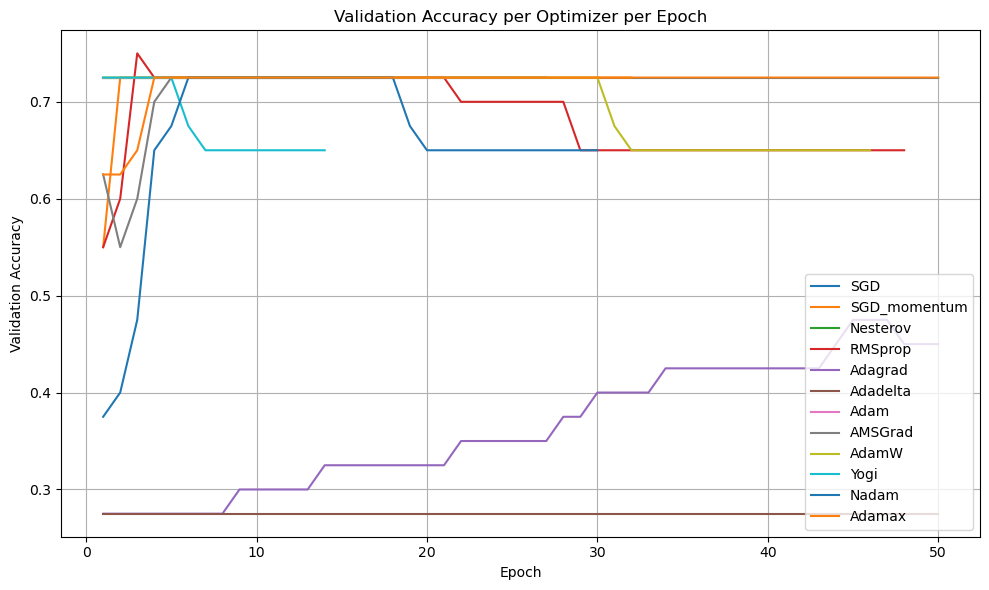

In [131]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot Test Accuracy per Optimizer per Epoch
plt.figure(figsize=(10, 6))

# Loop through results to access each optimizer's training history
for optimizer_name, result in results.items():
    # Retrieve the validation accuracy history for this optimizer
    if 'val_accuracy' in result['history'].history:
        val_acc_history = result['history'].history['val_accuracy']
    else:
        # Sometimes the key might be 'val_acc', depending on TensorFlow version
        val_acc_history = result['history'].history.get('val_acc', [])

    # Plot the validation accuracy history
    plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label=optimizer_name)

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy per Optimizer per Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


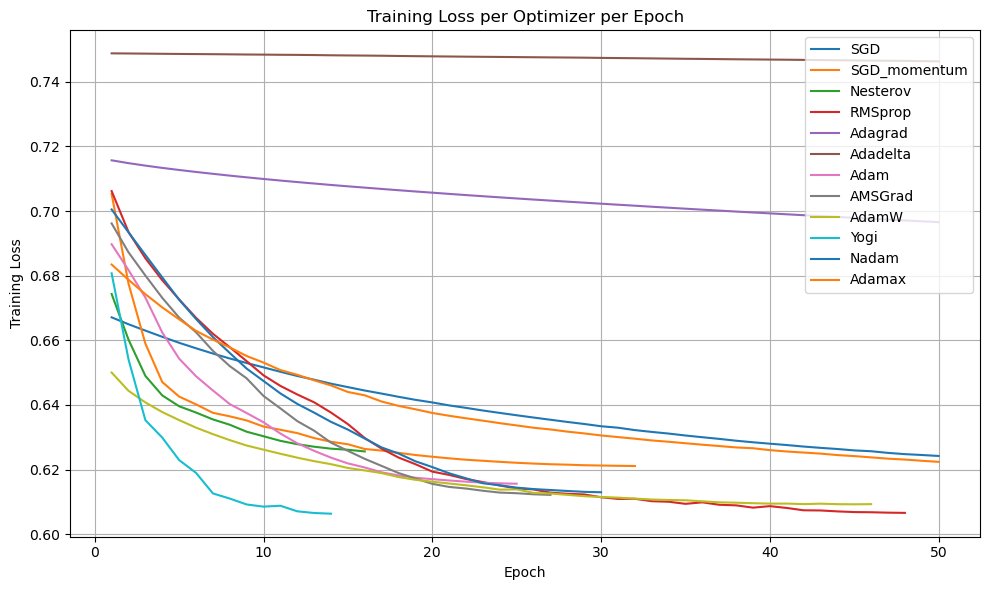

In [132]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot Training Loss per Optimizer per Epoch
plt.figure(figsize=(10, 6))

# Loop through results to access each optimizer's training history
for optimizer_name, result in results.items():
    # Retrieve the training loss history for this optimizer
    if 'loss' in result['history'].history:
        loss_history = result['history'].history['loss']
    else:
        # In case the loss key isn't found (unexpected behavior), use a default empty list
        loss_history = []

    # Plot the training loss history
    plt.plot(range(1, len(loss_history) + 1), loss_history, label=optimizer_name)

# Set plot labels and titles
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Optimizer per Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [133]:
final_df.to_csv('Predicting Student Admissions_nn_r(3).csv', index=False)

################## Before Presentation ####################################

In [10]:
import pandas as pd
import keras
from keras.utils import np_utils

class DataPreprocessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def load_data(self):
        self.data = pd.read_csv(self.file_path)

    def remove_nan(self):
        self.data = self.data.fillna(0)

    def one_hot_encode(self, columns):
        self.data = pd.get_dummies(self.data, columns=columns)

    def normalize(self, features):
        for feature in features:
            self.data[feature] = self.data[feature] / (800 if feature == 'gre' else 4)

    def preprocess(self):
        self.load_data()
        self.remove_nan()
        self.one_hot_encode(['rank'])
        self.normalize(['gre', 'gpa'])

        X = self.data.iloc[:, 1:].values.astype('float32')
        y = keras.utils.to_categorical(self.data["admit"], 2)

        self.X_train, self.X_test = X[50:], X[:50]
        self.y_train, self.y_test = y[50:], y[:50]




In [11]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils

class NeuralNetworkModel:
    def __init__(self):
        self.model = None

    def build_ann(self, input_shape, optimizer='adam'):
        self.model = Sequential()
        self.model.add(Dense(128, activation='relu', input_shape=(input_shape,)))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dropout(0.1))
        self.model.add(Dense(2, activation='softmax'))
        self.model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    def train(self, X_train, y_train, epochs=100, batch_size=32, validation_data=None):
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data)
        return history

    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test)


In [12]:
# Usage
preprocessor = DataPreprocessor('student_data.csv')
preprocessor.preprocess()

X_train, X_test = preprocessor.X_train, preprocessor.X_test
y_train, y_test = preprocessor.y_train, preprocessor.y_test

Training model with SGD optimizer...
Epoch 1/5
11/11 [==============================] - 2s 27ms/step - loss: 0.6887 - accuracy: 0.5200 - val_loss: 0.6850 - val_accuracy: 0.5600
Epoch 2/5
11/11 [==============================] - 0s 8ms/step - loss: 0.6610 - accuracy: 0.6514 - val_loss: 0.6835 - val_accuracy: 0.5600
Epoch 3/5
11/11 [==============================] - 0s 9ms/step - loss: 0.6458 - accuracy: 0.6971 - val_loss: 0.6851 - val_accuracy: 0.5600
Epoch 4/5
11/11 [==============================] - 0s 8ms/step - loss: 0.6354 - accuracy: 0.7000 - val_loss: 0.6878 - val_accuracy: 0.5600
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.5600
Training model with Adam optimizer...
Epoch 1/5
11/11 [==============================] - 1s 42ms/step - loss: 0.6152 - accuracy: 0.7114 - val_loss: 0.6955 - val_accuracy: 0.5600
Epoch 2/5
11/11 [==============================] - 0s 10ms/step - loss: 0.5989 - accuracy: 0.7000 - val_loss: 0.7296 - val_accuracy: 

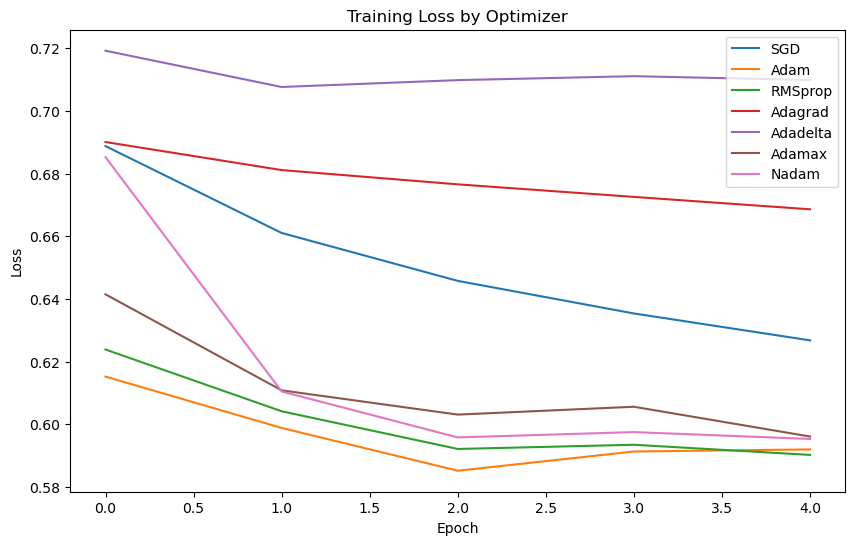

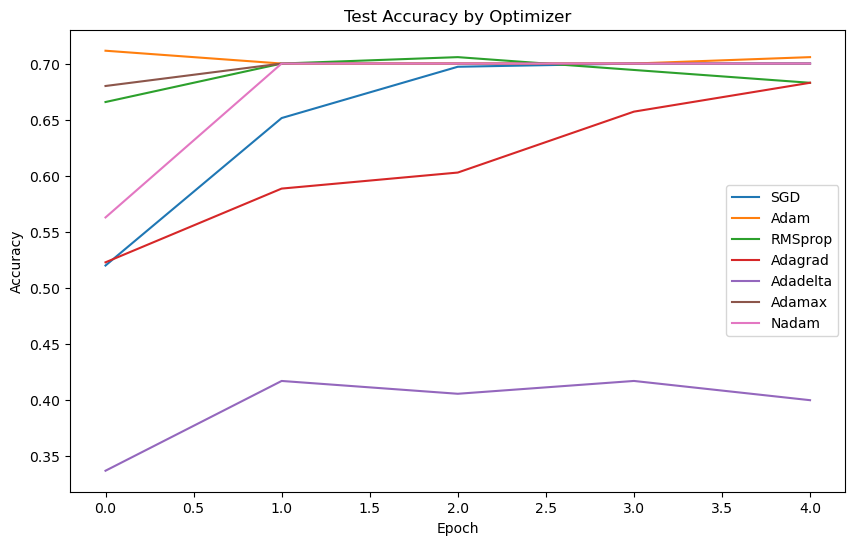

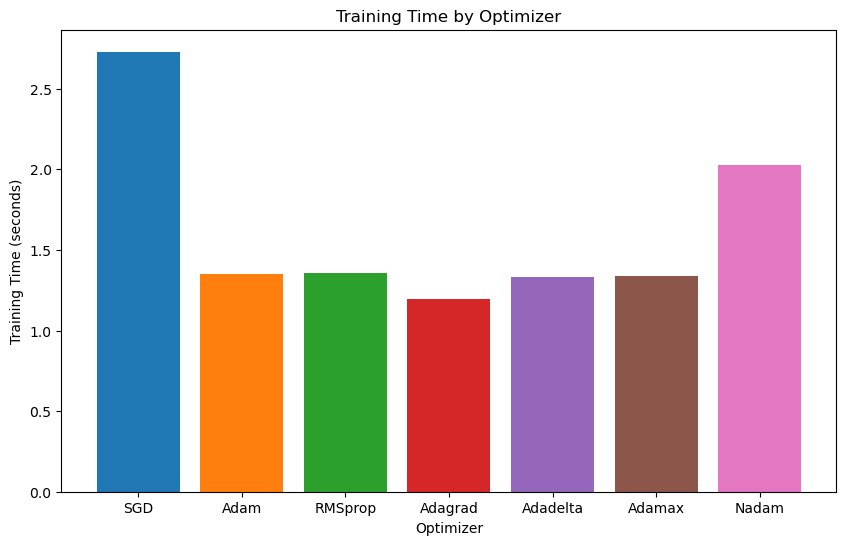

In [6]:
import time
import matplotlib.pyplot as plt

# List of optimizers to test for NN
optimizers = {
    'SGD': 'SGD',
    'Adam': 'adam',
    'RMSprop': 'RMSprop',
    'Adagrad': 'Adagrad',
    'Adadelta': 'Adadelta',
    'Adamax': 'Adamax',
    'Nadam': 'Nadam'
}

results = {}

for name, optimizer_name in optimizers.items():
    print(f"Training model with {name} optimizer...")
    model_instance = NeuralNetworkModel()
    model_instance.build_ann(X_train.shape[1], optimizer=optimizer_name)
    start_time = time.time()
    history = model_instance.train(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))
    end_time = time.time()
    test_loss, test_acc = model_instance.evaluate(X_test, y_test)
    training_time = end_time - start_time
    results[name] = {'test_accuracy': test_acc, 'convergence_speed': len(history.history['loss']), 'training_time': training_time, 'history': history}

# Print results
print("\nResults:")
for name, result in results.items():
    print(f"{name}: Test Accuracy - {result['test_accuracy']:.4f}, "
          f"Convergence Speed - {result['convergence_speed']} epochs, "
          f"Training Time - {result['training_time']:.2f} seconds")

# Plot training history
plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['history'].history['loss'], label=name)
plt.title('Training Loss by Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['history'].history['accuracy'], label=name)
plt.title('Test Accuracy by Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.bar(name, result['training_time'])
plt.title('Training Time by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Training Time (seconds)')
plt.show()


In [7]:
# Step 1: Collect results and metrics
optimizer_metrics = {}  # Dictionary to store optimizer metrics

for optimizer, result in results.items():
    accuracy = result['test_accuracy']
    loss = result['history'].history['loss'][-1]
    training_time = result['training_time']
    optimizer_metrics[optimizer] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# Step 2: Analyze metrics
best_optimizer = None
best_accuracy = 0
lowest_loss = float('inf')
shortest_training_time = float('inf')

for optimizer, metrics in optimizer_metrics.items():
    accuracy = metrics['accuracy']
    loss = metrics['loss']
    training_time = metrics['training_time']
    
    # Determine the best optimizer based on accuracy, loss, and training time
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        lowest_loss = loss
        shortest_training_time = training_time
        best_optimizer = optimizer
    elif accuracy == best_accuracy and loss < lowest_loss:
        lowest_loss = loss
        shortest_training_time = training_time
        best_optimizer = optimizer
    elif accuracy == best_accuracy and loss == lowest_loss and training_time < shortest_training_time:
        shortest_training_time = training_time
        best_optimizer = optimizer

# Step 3: Print or return the best performing optimizer
print(f"Best performing optimizer: {best_optimizer}")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"Loss: {lowest_loss:.4f}")
print(f"Shortest Training Time: {shortest_training_time:.2f} seconds")

Best performing optimizer: Adam
Accuracy: 0.6200
Loss: 0.5920
Shortest Training Time: 1.35 seconds


Comparison of Optimizers:
          accuracy      loss  training_time
SGD           0.56  0.626788       2.729217
Adam          0.62  0.592012       1.349207
RMSprop       0.56  0.590263       1.357234
Adagrad       0.56  0.668590       1.193760
Adadelta      0.34  0.709799       1.330082
Adamax        0.56  0.596120       1.339168
Nadam         0.56  0.595351       2.027313


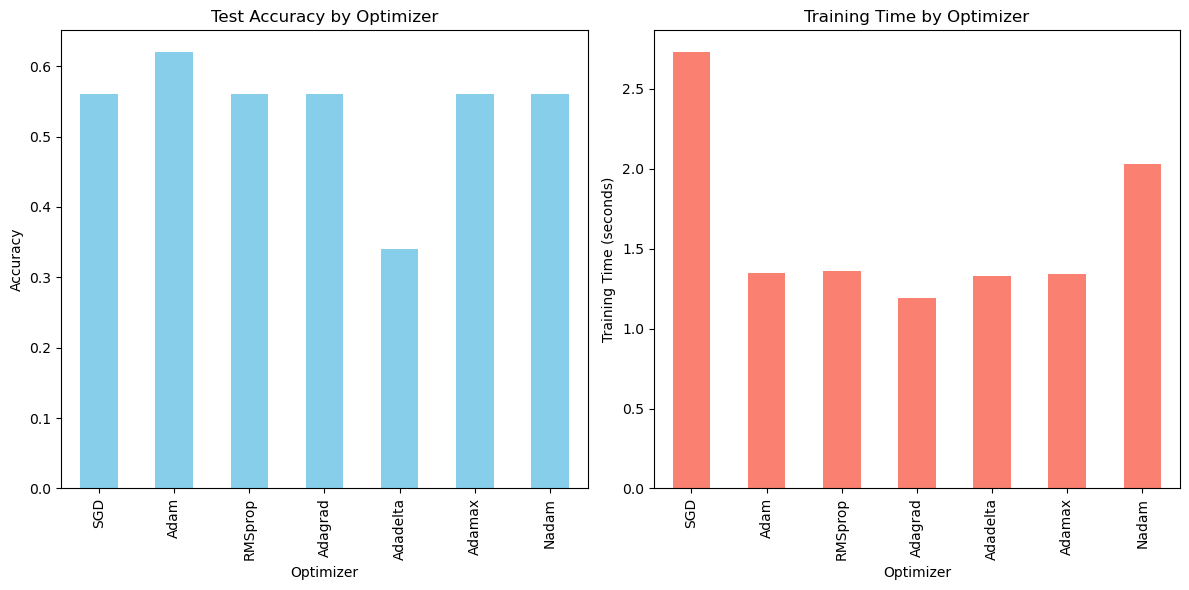

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Collect results and metrics
optimizer_metrics = {}  # Dictionary to store optimizer metrics

for optimizer, result in results.items():
    accuracy = result['test_accuracy']
    loss = result['history'].history['loss'][-1]
    training_time = result['training_time']
    optimizer_metrics[optimizer] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# Step 2: Create a dataframe for comparison
df = pd.DataFrame(optimizer_metrics).T  # Transpose to have optimizers as rows

# Step 3: Plot the comparison using a table
print("Comparison of Optimizers:")
print(df)

# Step 4: Plot the comparison using a graph
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df['accuracy'].plot(kind='bar', color='skyblue')
plt.title('Test Accuracy by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
df['training_time'].plot(kind='bar', color='salmon')
plt.title('Training Time by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Training Time (seconds)')

plt.tight_layout()
plt.show()


In [1]:
pip install tensorflow-addons


Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
import tensorflow_addons as tfa


In [4]:
import pandas as pd
import keras
from keras.utils import np_utils

class DataPreprocessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def load_data(self):
        self.data = pd.read_csv(self.file_path)

    def remove_nan(self):
        self.data = self.data.fillna(0)

    def one_hot_encode(self, columns):
        self.data = pd.get_dummies(self.data, columns=columns)

    def normalize(self, features):
        for feature in features:
            self.data[feature] = self.data[feature] / (800 if feature == 'gre' else 4)

    def preprocess(self):
        self.load_data()
        self.remove_nan()
        self.one_hot_encode(['rank'])
        self.normalize(['gre', 'gpa'])

        X = self.data.iloc[:, 1:].values.astype('float32')
        y = keras.utils.to_categorical(self.data["admit"], 2)

        self.X_train, self.X_test = X[50:], X[:50]
        self.y_train, self.y_test = y[50:], y[:50]

In [5]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils

class NeuralNetworkModel:
    def __init__(self):
        self.model = None

    def build_ann(self, input_shape, optimizer=tf.keras.optimizers.Adam()):
        self.model = Sequential()
        self.model.add(Dense(128, activation='relu', input_shape=(input_shape,)))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dropout(0.1))
        self.model.add(Dense(2, activation='softmax'))
        self.model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


    def train(self, X_train, y_train, epochs=100, batch_size=32, validation_data=None):
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data)
        return history

    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test)


In [6]:
# Usage
preprocessor = DataPreprocessor('student_data.csv')
preprocessor.preprocess()

X_train, X_test = preprocessor.X_train, preprocessor.X_test
y_train, y_test = preprocessor.y_train, preprocessor.y_test

Training model with SGD optimizer...
Epoch 1/100
11/11 [==============================] - 2s 24ms/step - loss: 0.7197 - accuracy: 0.4400 - val_loss: 0.6892 - val_accuracy: 0.4600
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6840 - accuracy: 0.5714 - val_loss: 0.6846 - val_accuracy: 0.5600
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6513 - accuracy: 0.6743 - val_loss: 0.6863 - val_accuracy: 0.5600
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6344 - accuracy: 0.6829 - val_loss: 0.6912 - val_accuracy: 0.5600
Epoch 5/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6277 - accuracy: 0.7000 - val_loss: 0.6957 - val_accuracy: 0.5600
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6231 - accuracy: 0.7000 - val_loss: 0.7000 - val_accuracy: 0.5600
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6177 - accuracy: 0.7000 - val_loss: 0.704

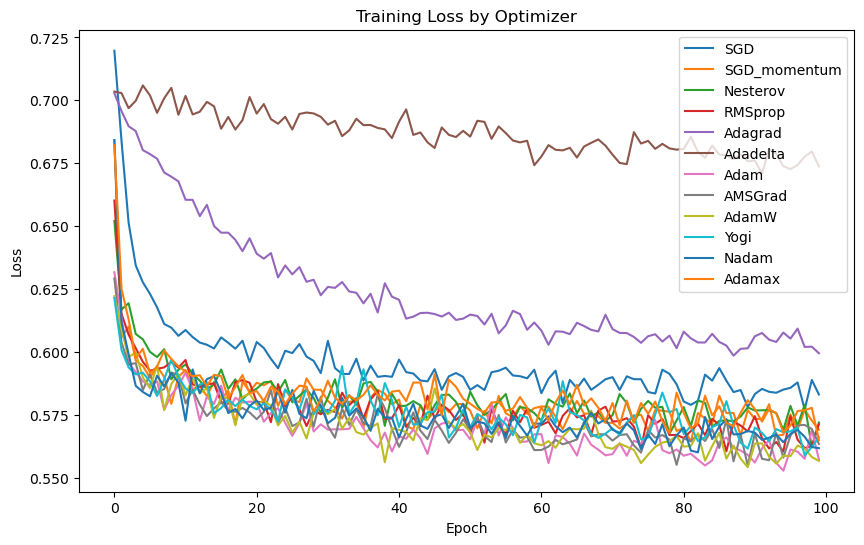

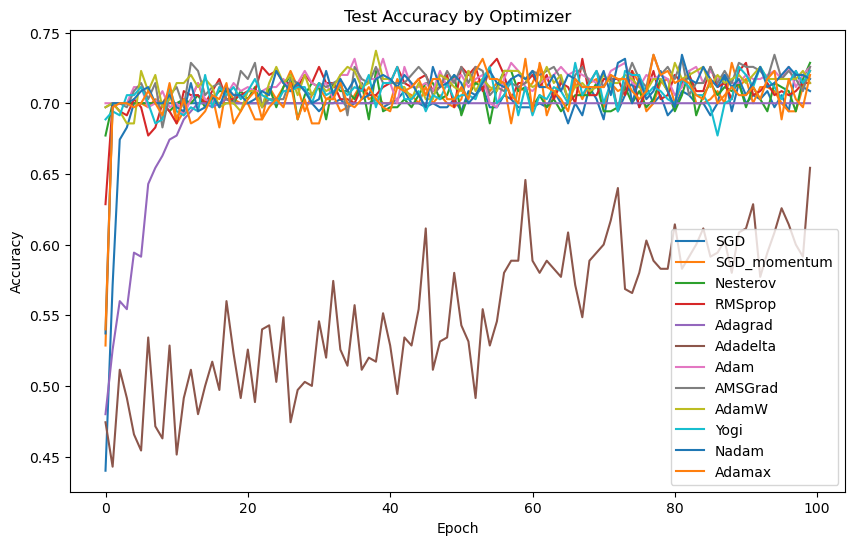

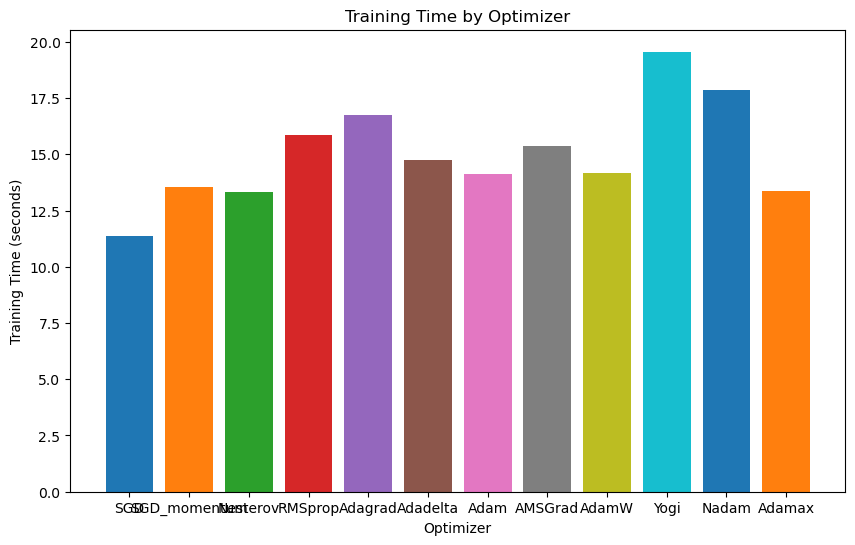

In [7]:
import time
import matplotlib.pyplot as plt

# List of optimizers to test for NN
optimizers = {
    'SGD': tf.keras.optimizers.SGD(),
    'SGD_momentum': tf.keras.optimizers.SGD(momentum=0.9),
    'Nesterov': tf.keras.optimizers.SGD(momentum=0.9, nesterov=True),
    'RMSprop': tf.keras.optimizers.RMSprop(),
    'Adagrad': tf.keras.optimizers.Adagrad(),
    'Adadelta': tf.keras.optimizers.Adadelta(),
    'Adam': tf.keras.optimizers.Adam(),
    'AMSGrad': tf.keras.optimizers.Adam(amsgrad=True),
    'AdamW': tfa.optimizers.AdamW(weight_decay=1e-4),
    'Yogi': tfa.optimizers.Yogi(),
    'Nadam': tf.keras.optimizers.Nadam(),
    'Adamax': tf.keras.optimizers.Adamax()
}

results = {}

for name, optimizer in optimizers.items():
    print(f"Training model with {name} optimizer...")
    model_instance = NeuralNetworkModel()
    model_instance.build_ann(X_train.shape[1], optimizer=optimizer)
    start_time = time.time()
    history = model_instance.train(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))
    end_time = time.time()
    test_loss, test_acc = model_instance.evaluate(X_test, y_test)
    training_time = end_time - start_time
    results[name] = {'test_accuracy': test_acc, 'convergence_speed': len(history.history['loss']), 'training_time': training_time, 'history': history}

# Print results
print("\nResults:")
for name, result in results.items():
    print(f"{name}: Test Accuracy - {result['test_accuracy']:.4f}, "
          f"Convergence Speed - {result['convergence_speed']} epochs, "
          f"Training Time - {result['training_time']:.2f} seconds")

# Plot training history
plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['history'].history['loss'], label=name)
plt.title('Training Loss by Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['history'].history['accuracy'], label=name)
plt.title('Test Accuracy by Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.bar(name, result['training_time'])
plt.title('Training Time by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Training Time (seconds)')
plt.show()


In [10]:
# Assumption: The 'results' dictionary has been filled with training data as in your original code.

# Step 1: Collect results and metrics
optimizer_metrics = {}  # Dictionary to store optimizer metrics

for name, result in results.items():
    accuracy = result['test_accuracy']
    loss = result['history'].history['loss'][-1]  # Get the last loss value
    training_time = result['training_time']
    optimizer_metrics[name] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# Step 2: Analyze metrics
best_optimizer = None
best_accuracy = 0
lowest_loss = float('inf')
shortest_training_time = float('inf')

for name, metrics in optimizer_metrics.items():
    accuracy = metrics['accuracy']
    loss = metrics['loss']
    training_time = metrics['training_time']
    
    # Determine the best optimizer based on accuracy, loss, and training time
    if accuracy > best_accuracy or (accuracy == best_accuracy and loss < lowest_loss):
        best_accuracy = accuracy
        lowest_loss = loss
        shortest_training_time = training_time
        best_optimizer = name
    elif accuracy == best_accuracy and loss == lowest_loss and training_time < shortest_training_time:
        shortest_training_time = training_time
        best_optimizer = name

# Step 3: Print or return the best performing optimizer
print(f"Best performing optimizer: {best_optimizer}")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"Loss: {lowest_loss:.4f}")
print(f"Shortest Training Time: {shortest_training_time:.2f} seconds")


Best performing optimizer: AdamW
Accuracy: 0.6800
Loss: 0.5566
Shortest Training Time: 14.15 seconds


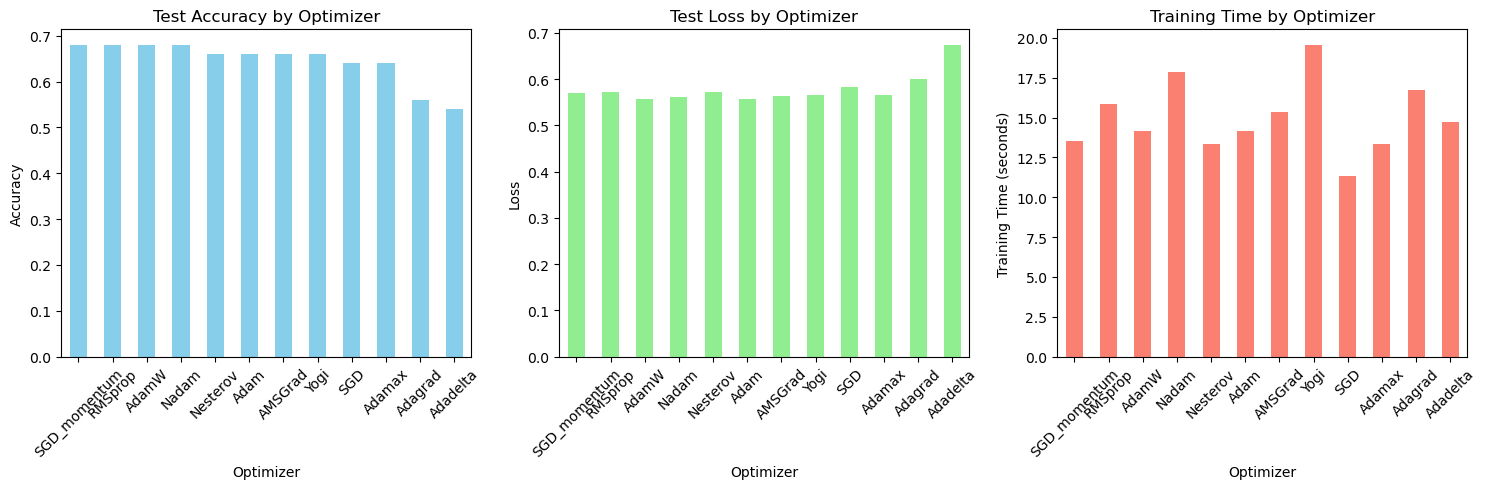

Comparison of Optimizers:
              accuracy      loss  training_time
SGD_momentum      0.68  0.569023      13.555485
RMSprop           0.68  0.571236      15.857892
AdamW             0.68  0.556646      14.150158
Nadam             0.68  0.561730      17.855766
Nesterov          0.66  0.571940      13.318884
Adam              0.66  0.557241      14.135928
AMSGrad           0.66  0.563416      15.351609
Yogi              0.66  0.566009      19.564182
SGD               0.64  0.583067      11.361061
Adamax            0.64  0.564888      13.370035
Adagrad           0.56  0.599453      16.734178
Adadelta          0.54  0.673740      14.740053


In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the 'results' dictionary is populated with the training results from the earlier code

# Step 1: Collect results and metrics
optimizer_metrics = {}  # Dictionary to store optimizer metrics

for name, result in results.items():
    accuracy = result['test_accuracy']
    loss_history = result['history'].history['loss']
    if len(loss_history) > 0:  # Ensure there is at least one loss value
        loss = loss_history[-1]  # Get the last loss value
    else:
        loss = None
    training_time = result['training_time']
    optimizer_metrics[name] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# Step 2: Create a dataframe for comparison
df = pd.DataFrame(optimizer_metrics).T  # Transpose to have optimizers as rows
df.sort_values('accuracy', ascending=False, inplace=True)  # Sort by accuracy in descending order

# Step 3: Plot the comparison using a graph
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df['accuracy'].plot(kind='bar', color='skyblue')
plt.title('Test Accuracy by Optimizer')
plt.xlabel('Optimizer')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')

plt.subplot(1, 3, 2)
df['loss'].plot(kind='bar', color='lightgreen')
plt.title('Test Loss by Optimizer')
plt.xlabel('Optimizer')
plt.xticks(rotation=45)
plt.ylabel('Loss')

plt.subplot(1, 3, 3)
df['training_time'].plot(kind='bar', color='salmon')
plt.title('Training Time by Optimizer')
plt.xlabel('Optimizer')
plt.xticks(rotation=45)
plt.ylabel('Training Time (seconds)')

plt.tight_layout()
plt.show()

# Step 4: Optionally, print the DataFrame for a text-based comparison
print("Comparison of Optimizers:")
print(df)